In [2]:
# utilities
import re
import os
import csv
import pandas as pd
# plotting
from wordcloud import WordCloud
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from functions import preprocess, writeFile, stopwordlist

In [4]:
if not os.path.isfile('combined.txt'):
    # Open the output file for writing
    with open('combined.txt', 'w') as outfile:
        path = '/Users/christiedjidjev/Library/CloudStorage/OneDrive-Personal/Classes/Twitter Sentiment/archive (1)/'
        # Loop through the input files
        for filename in [path + '2018-E-c-En-dev.txt', path + '2018-E-c-En-test-gold.txt', path + '2018-E-c-En-train.txt']:
            # Open the input file for reading
            with open(filename, 'r') as infile:
                # Write the contents of the input file to the output file
                outfile.write(infile.read())
    # Open the input text file and read the data
    with open('combined.txt', 'r') as f:
        data = [line.strip().split('\t') for line in f.readlines()]

    # Write the data to a CSV file
    with open('Project_Data.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)

In [5]:
# Importing the SemEval -18 emotions dataset
DATASET_COLUMNS=['ID','Tweet','anger','anticipation','disgust','fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/Users/christiedjidjev/Library/CloudStorage/OneDrive-Personal/Classes/Twitter Sentiment/Project_Data.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
3730,2018-En-00536,Looking for Lyft promo code? Use this for $50:...,0,0,0,0,1,0,1,0,0,0,1
1892,2018-En-00195,I get so heated when I see people go to Thaila...,1,0,1,0,0,0,0,0,0,0,0
9485,2017-En-40472,"@VileBairn Turning then, the older woman looke...",0,0,0,0,0,0,0,0,0,0,0
4286,2017-En-11436,@Bungie spent over 2 fucking hours and still c...,1,0,1,0,0,0,0,0,0,0,0
6788,2017-En-30329,Punchline king is back! @Paedeezy ð¥ð¥ð¥...,0,0,0,0,1,0,1,0,0,0,0


In [6]:
emotions = ['anger','anticipation','disgust','fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
num_occurences = []
for e in emotions:
    count = (df[e] == '1').sum()
    num_occurences.append(count)
print(num_occurences)

[3960, 1527, 4020, 1848, 4318, 1348, 3433, 1270, 3233, 566, 553]


In [7]:
print('Count of rows in the data is:  ', len(df))

Count of rows in the data is:   10983


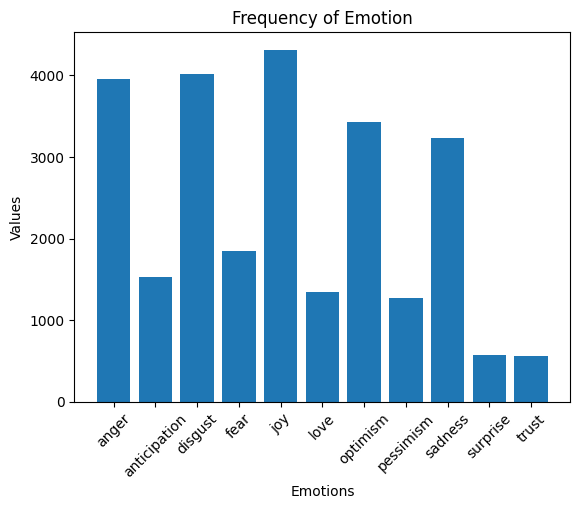

In [8]:
import matplotlib.pyplot as plt 

# Plotting the distribution for dataset.
plt.bar(emotions, num_occurences)

# Set chart title and axis labels
plt.title('Frequency of Emotion')
plt.xlabel('Emotions')
plt.ylabel('Values')
plt.xticks(rotation=45)

# Show chart
plt.show()

In [9]:
#choosing the tweet text for preprocessing
dataset=df[['Tweet']]

#preprocessing the tweet text 
dataset = preprocess(dataset)

#setting the emotion targets
targets = df[['anger','anticipation','disgust','fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']] 

/Users/christiedjidjev/Library/CloudStorage/OneDrive-Personal/Classes/Twitter Sentiment/functions.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Tweet'] = dataset['Tweet'].apply(lambda text: cleaning_stopwords(text))
/Users/christiedjidjev/Library/CloudStorage/OneDrive-Personal/Classes/Twitter Sentiment/functions.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Tweet']= dataset['Tweet'].apply(lambda x: cleaning_punctuations(x))
/Users/christiedjidjev/Library/CloudStorage/OneDrive

In [10]:
#putting words back into a single string
dataset['Tweet'] = dataset['Tweet'].apply(lambda x: ' '.join(x))
dataset['Tweet'].head()
dataset_copy = dataset.copy()

/var/folders/ld/4858sm992td86smbqcp88pwh0000gn/T/ipykernel_53270/550032675.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Tweet'] = dataset['Tweet'].apply(lambda x: ' '.join(x))


In [11]:
from sklearn.metrics import roc_curve, auc

def apply_ML_model(X_train, y_train, method, function):
    if method == 'log_regression':
        model = function(C = 2, max_iter = 500, n_jobs=-1)
    else:
        model = function()

    model.fit(X_train, y_train)

    return model

In [12]:
#ml part
trained_models = {e:{} for e in emotions}

for em in emotions:
    X=dataset.Tweet
    y=targets[em]

    # Separating the 95% data for training data and 5% for testing data
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

    vectoriser = TfidfVectorizer(ngram_range=(1,1), max_features=500000)
    vectoriser.fit(X_train)
    #print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

    X_train = vectoriser.transform(X_train)
    X_test  = vectoriser.transform(X_test)

    methods = ['BernoulliNB', 'log_regression', 'SVCmodel']
    functions = [BernoulliNB, LogisticRegression, LinearSVC ]


    for i, method in enumerate(methods):
        trained_models[em][method] = apply_ML_model(X_train, y_train, method=method, function = functions[i])


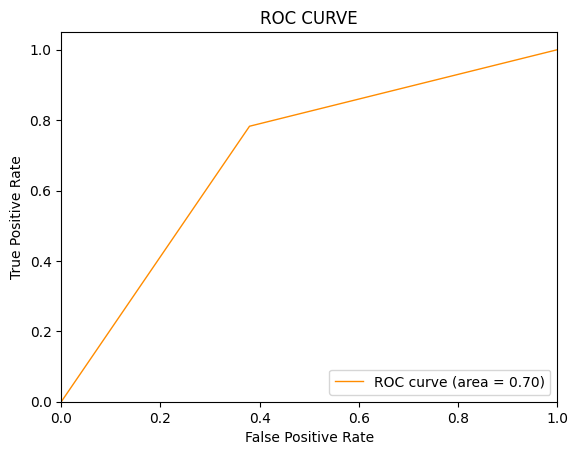

In [13]:
# apply models to make predictions for the emotions of new tweets
best_method = {'anger':'SVCmodel', 'anticipation':'SVCmodel', 'fear':'BernoulliNB','joy':'SVCmodel',\
               'love':'SVCmodel','optimism':'log_regression','pessimism':'BernoulliNB'}
em = 'joy'
model = trained_models[em][best_method[em]]
y_pred = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test.astype(int), y_pred.astype(int))
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.savefig(method+'_roc.pdf')

In [14]:
#saves trained models and vectorizer in a compressed file
fileName = '/Users/christiedjidjev/Downloads/Twitter Sentiment/training.txt'
data = (trained_models, vectoriser) 

writeFile(fileName, data)

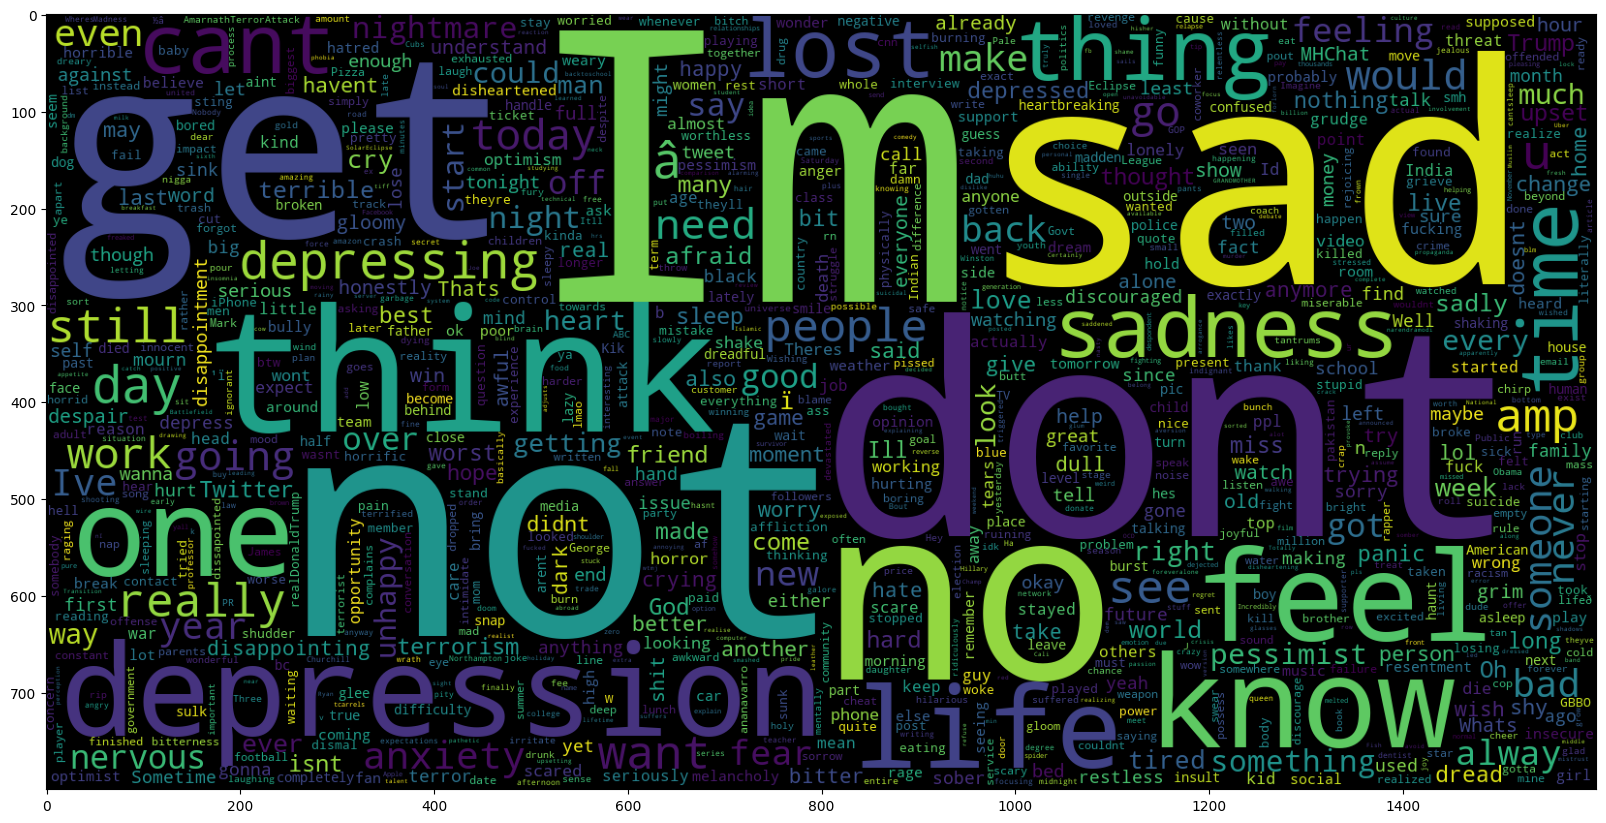

In [15]:
#creating a word cloud from tweets containing emotion em
em = 'joy'
data_em = dataset[targets['pessimism'] == '1']
data = data_em['Tweet']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, stopwords=stopwordlist,
               collocations=False).generate(" ".join(data))
plt.imshow(wc)